In [2]:
#TODO
# - Restrict to short equations < 50
# - Crop more

### Import Modules

In [3]:
# To plot learning curve graph
%matplotlib inline
import matplotlib.pyplot as plt

# for pretty print
from pprint import pprint

# for tokenizer
import re

# for word counter in vocabulary dictionary
from collections import Counter

# for checkpoint paths
import os

# for fancy progress bar
from tqdm import tqdm

# TensorFlow
import tensorflow as tf

# for output_projection
from tensorflow.python.layers.core import Dense

# for initial attention (not required ver1.2+)
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors

import os
import numpy as np

### Sample training data

In [4]:
path = 'eq_images/cropped'
files = list(set(os.listdir(os.path.join(path,'images'))) - set(['.DS_Store']))
imbeds = list(set(os.listdir('imbeddings2')) - set(['.DS_Store']))

In [5]:
with open(os.path.join(path, '/Users/user/eecs/Deep_Learning/im2latex/im2latex_train.lst')) as fl:
    ids = fl.readlines()
    

In [6]:
id_name_pairs = [(id_[:-1].split())[:-1] for id_ in ids]
imbed2id = dict([(name+'.npy',int(id_)) for id_, name in id_name_pairs])
im2id = dict([(name+'.png',int(id_)) for id_, name in id_name_pairs])

In [7]:
with open('/Users/user/eecs/Deep_Learning/im2latex/im2latex_formulas.lst','rb') as f:
    eqs = f.readlines()

In [8]:
eqs = np.array(eqs)

In [9]:
train_eqs = eqs[list(map(imbed2id.get,imbeds))]

In [10]:
choice = np.random.randint(0,len(files))
choice

36000

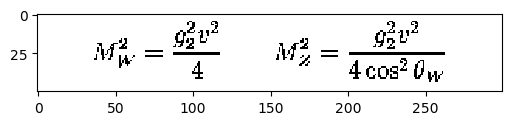

In [11]:
plt.imshow(plt.imread(os.path.join(path,'images',imbeds[choice][:-4]+'.png')))

In [12]:
train_eqs[choice]

b'M_W^2 = {g^2_2 v^2 \\over 4} \\qquad M_Z^2 =  {g^2_2 v^2 \\over 4 \\cos^2 \\theta_W}\n'

In [13]:
from nltk.tokenize import RegexpTokenizer

def tokenizer(sentence):
    tokenizer_ = RegexpTokenizer('\\\\[A-Za-z]+|\\\\\S|\[A-Za-z]+|\d|\S')
    if type(sentence) is not str:
        sentence = sentence.decode()
    return tokenizer_.tokenize(sentence)

# Example
tokenizer("xy")

['x', 'y']

In [14]:
from nltk.tokenize import RegexpTokenizer
import re

def replace_label(sentence):
    if type(sentence) is not str:
        sentence = sentence.decode()
    return re.sub(string=sentence,
                      pattern=r'\\label\{[^\}]+\}',
                      repl='')


def tokenizer_no_label(sentence):
    tokenizer_ = RegexpTokenizer('\\\\[A-Za-z]+|\\\\\S|\[A-Za-z]+|\d|\S')
    sentence = replace_label(sentence)
    return tokenizer_.tokenize(sentence)

# Example
tokenizer_no_label("xy \\label{this is a label} + z")

['x', 'y', '+', 'z']

In [15]:
def get_length(eq):
    try:
        return len(tokenizer_no_label(eq))
    except:
        return np.inf

In [16]:
imgs = [np.load(os.path.join('imbeddings2',imbed)) for imbed in imbeds]

In [17]:
len(imgs)

40276

Be lazy and retain a multiple of 128 for quick batching without iterators and generators

In [18]:
num_ex= 128*(len(imgs)//128)
num_ex

40192

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x_tr, x_val, y_tr, y_val = train_test_split(imgs, train_eqs, test_size=0.2)

In [21]:
target_batches = [y_tr[i:i+128] for i in range(0,len(y_tr),128)]

In [23]:
input_batches = [x_tr[i:i+128] for i in range(0,len(x_tr),128)]

In [24]:
all_target_sentences = []
for target_batch in target_batches:
    all_target_sentences.extend(target_batch)

### NLP helper functions

In [25]:
def build_vocab(sentences, max_vocab_size=None, verbose = False):
    word_counter = Counter()
    vocab = dict()
    reverse_vocab = dict()
    
    for sentence in sentences:
        try:
            tokens = tokenizer_no_label(sentence)
            word_counter.update(tokens)
        except:
            if verbose:
                print(sentence)
            continue
        
    if max_vocab_size is None:
        max_vocab_size = len(word_counter)

    vocab['_GO'] = 1
    vocab['_PAD'] = 0
    vocab_idx = 2
    for key, value in word_counter.most_common(max_vocab_size):
        vocab[key] = vocab_idx
        vocab_idx += 1
        
    for key, value in vocab.items():
        reverse_vocab[value] = key
            
    return vocab, reverse_vocab, max_vocab_size


pprint(build_vocab(all_target_sentences))

({'!': 184,
  '"': 320,
  '$': 174,
  '%': 138,
  '&': 148,
  "'": 62,
  '(': 7,
  ')': 6,
  '*': 118,
  '+': 13,
  ',': 10,
  '-': 12,
  '.': 15,
  '/': 86,
  '0': 16,
  '1': 11,
  '2': 9,
  '3': 40,
  '4': 45,
  '5': 116,
  '6': 127,
  '7': 169,
  '8': 135,
  '9': 171,
  ':': 147,
  ';': 136,
  '<': 141,
  '=': 8,
  '>': 137,
  '?': 360,
  '@': 440,
  'A': 27,
  'B': 68,
  'C': 83,
  'D': 65,
  'E': 85,
  'F': 69,
  'G': 89,
  'H': 76,
  'I': 94,
  'J': 98,
  'K': 107,
  'L': 64,
  'M': 60,
  'N': 61,
  'O': 143,
  'P': 82,
  'Q': 97,
  'R': 59,
  'S': 52,
  'T': 58,
  'U': 111,
  'V': 81,
  'W': 105,
  'X': 90,
  'Y': 153,
  'Z': 113,
  '[': 48,
  '\\': 33,
  '\\!': 155,
  '\\#': 268,
  '\\$': 399,
  '\\%': 438,
  '\\&': 446,
  '\\,': 20,
  '\\-': 400,
  '\\/': 322,
  '\\:': 158,
  '\\;': 31,
  '\\>': 214,
  '\\AA': 444,
  '\\Big': 192,
  '\\Bigg': 323,
  '\\Biggl': 316,
  '\\Biggr': 313,
  '\\Bigl': 225,
  '\\Bigr': 224,
  '\\Box': 470,
  '\\Delta': 112,
  '\\Gamma': 109,
  '\\Huge

In [26]:
# enc_vocab, enc_reverse_vocab, enc_vocab_size = build_vocab(all_input_sentences)
dec_vocab, dec_reverse_vocab, dec_vocab_size = build_vocab(all_target_sentences)

# print('input vocabulary size:', enc_vocab_size)
print('target vocabulary size:', dec_vocab_size)


target vocabulary size: 476


In [27]:
def token2idx(word, vocab):
    return vocab[word]

for token in tokenizer_no_label('V = \\frac{1}{3} \\label{1} \\pi r^2 h'):
    print(token, token2idx(token, dec_vocab))

V 81
= 8
\frac 17
{ 3
1 11
} 2
{ 3
3 40
} 2
\pi 50
r 24
^ 5
2 9
h 96


In [28]:
dec_sentence_length = 50

In [29]:
def sent2idx(sent, vocab, max_sentence_length, verbose=False):
    try:
        tokens = tokenizer_no_label(sent)[:max_sentence_length]
    except:
        if verbose:
            print(sent)
        tokens = ['_PAD']*max_sentence_length
    current_length = len(tokens)
    pad_length = max_sentence_length - current_length
    return [1] + [token2idx(token, vocab) for token in tokens] + [0] * pad_length, current_length
#     else:
#         return [token2idx(token, vocab) for token in tokens] + [0] * pad_length, current_length

# Enc Example
# print('Hi What is your name?')
# print(sent2idx('Hi What is your name?'))

# Dec Example
print('V = \\frac{1}{3}\\label{label}\\pi r^2 h')
print(sent2idx('V = \\frac{1}{3}\\label{label}\\pi r^2 h', vocab=dec_vocab, max_sentence_length=dec_sentence_length))

V = \frac{1}{3}\label{label}\pi r^2 h
([1, 81, 8, 17, 3, 11, 2, 3, 40, 2, 50, 24, 5, 9, 96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 14)


In [30]:
def idx2token(idx, reverse_vocab):
    return reverse_vocab[idx]

def idx2sent(indices, reverse_vocab=dec_reverse_vocab, replace_pad = True):
    sent = " ".join([idx2token(idx, reverse_vocab) for idx in indices])
    if replace_pad:
        return sent.replace(' _PAD','')
    return sent

### Hyperparameters / Path

In [31]:
h,w,_ = input_batches[0][0].shape
h,w

(6, 37)

In [32]:
len(dec_reverse_vocab)

478

In [33]:
class DemoConfig:
    
    # Model
    hidden_size = 256
    dec_emb_size = len(dec_reverse_vocab)
    dec_sent_length = 50
    enc_emb_size = 256
    attn_size = 256
    cell = tf.contrib.rnn.BasicLSTMCell
    beam_width = 5
    num_filters = [32, 64, 128]
    img_height = h
    img_width = w
    L = 124
    
    # Training
    optimizer = tf.train.RMSPropOptimizer
    n_epoch = 10
    learning_rate = 0.001
    conv_dropout = 0.25
    dense_dropout = 0.5
    
    # Tokens
    start_token = 1 # GO
    end_token = 0 # PAD

    # Checkpoint Path
    ckpt_dir = './ckpt_dir/'

### Build Graph

In [34]:
tf.nn.embedding_lookup

<function tensorflow.python.ops.embedding_ops.embedding_lookup>

In [35]:
class Seq2SeqModel(object):
    def __init__(self, config, mode='training'):
        assert mode in ['training', 'evaluation', 'inference']
        self.mode = mode

        # Model
#         self.hidden_size = config.hidden_size
        self.dec_emb_size = config.dec_emb_size
        self.enc_emb_size = config.enc_emb_size
        self.dec_sent_length = config.dec_sent_length
        self.attn_size = config.attn_size
        self.cell = config.cell
        self.beam_width = config.beam_width
        self.num_filters = config.num_filters
        self.img_height = config.img_height
        self.img_width = config.img_width
        
        # Training
        self.optimizer = config.optimizer
        self.n_epoch = config.n_epoch
        self.learning_rate = config.learning_rate
        
        
        # Tokens
        self.start_token = config.start_token
        self.end_token = config.end_token
        
        # Checkpoint Path
        self.ckpt_dir = config.ckpt_dir
        
    def add_placeholders(self):

        if self.mode == 'training':
            self.dec_inputs = tf.placeholder(
                tf.int32,
                shape=[None, self.dec_sent_length+1],
                name='target_sentences')

            self.dec_sequence_length = tf.placeholder(
                tf.int32,
                shape=[None,],
                name='target_sequence_length')
        
        self.vgg_features = tf.placeholder(tf.float32,
                                         shape = [None, self.img_height, self.img_width, self.enc_emb_size])
        
        self.imbeds = tf.reshape(self.vgg_features,
                                      shape = [-1,self.img_height*self.img_width, self.enc_emb_size])
        
            
            
    def add_decoder(self):
        with tf.variable_scope('Decoder') as scope:
            # get dynamic batch_size
            batch_size = tf.shape(self.imbeds)[0]

            dec_cell = self.cell(self.enc_emb_size)
            
            attn_mech = tf.contrib.seq2seq.BahdanauAttention(
                num_units=self.attn_size,
                memory=self.imbeds,
                name='BahdanauAttention')

            dec_cell = tf.contrib.seq2seq.AttentionWrapper(
                cell=dec_cell,
                attention_mechanism=attn_mech,
                name='Attention_Wrapper')
            

            # output projection (replacing `OutputProjectionWrapper`)
            output_layer = Dense(dec_vocab_size+2, name='output_projection')
            
            if self.mode == 'training':

                # maxium unrollings in current batch = max(dec_sent_len) + 1(GO symbol)
                max_dec_len = tf.reduce_max(self.dec_sequence_length+1, name='max_dec_len')
                
                embedding_matrix = np.float32(np.eye(self.dec_emb_size))
                
                
#                 dec_emb_inputs = tf.one_hot(self.dec_inputs, depth = self.dec_emb_size)

                dec_emb_inputs = tf.nn.embedding_lookup(params=embedding_matrix, ids=self.dec_inputs)
    
                training_helper = tf.contrib.seq2seq.TrainingHelper(
                    inputs=dec_emb_inputs,
                    sequence_length=self.dec_sequence_length+1,
                    time_major=False,
                    name='training_helper')

                training_decoder = tf.contrib.seq2seq.BasicDecoder(
                    cell=dec_cell,
                    helper=training_helper,
                    initial_state = dec_cell.zero_state(batch_size, tf.float32),
                    output_layer=output_layer) 

                train_dec_outputs, train_dec_last_state, train_dec_last_lengths = tf.contrib.seq2seq.dynamic_decode(
                    training_decoder,
                    output_time_major=False,
                    impute_finished=True,
                    maximum_iterations=max_dec_len)
                
                # dec_outputs: collections.namedtuple(rnn_outputs, sample_id)
                # dec_outputs.rnn_output: [batch_size x max(dec_sequence_len) x dec_vocab_size+2], tf.float32
                # dec_outputs.sample_id [batch_size], tf.int32
                
                # logits: [batch_size x max_dec_len x dec_vocab_size+2]
                logits = tf.identity(train_dec_outputs.rnn_output, name='logits')
                
                # targets: [batch_size x max_dec_len x dec_vocab_size+2]
                targets = tf.slice(self.dec_inputs, [0, 0], [-1, max_dec_len], 'targets')
                
                # masks: [batch_size x max_dec_len]
                # => ignore outputs after `dec_senquence_length+1` when calculating loss
                masks = tf.sequence_mask(self.dec_sequence_length+1, 
                                         max_dec_len, dtype=tf.float32, name='masks')
                
                # Control loss dimensions with `average_across_timesteps` and `average_across_batch`
                # internal: `tf.nn.sparse_softmax_cross_entropy_with_logits`
                self.batch_loss = tf.contrib.seq2seq.sequence_loss(
                    logits=logits,
                    targets=targets,
                    weights=masks,
                    name='batch_loss')
                
                # prediction sample for validation
                self.valid_predictions = tf.identity(train_dec_outputs.sample_id, name='valid_preds')

                # List of training variables
                # self.training_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
            
            elif self.mode == 'inference':
            
                start_tokens = tf.tile(tf.constant([self.start_token], dtype=tf.int32), 
                                       [batch_size], name='start_tokens')
            
                inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper( 
#                     embedding=self.dec_Wemb,
                    embedding = tf.one_hot(np.arange(self.dec_emb_size),depth = self.dec_emb_size),
                    start_tokens=start_tokens,
                    end_token=self.end_token)
                
                inference_decoder = tf.contrib.seq2seq.BasicDecoder(
                    cell=dec_cell,
                    helper=inference_helper,
                    initial_state=dec_cell.zero_state(batch_size, tf.float32),
                    output_layer=output_layer)
                
                infer_dec_outputs, infer_dec_last_state, infer_dec_last_lengths = tf.contrib.seq2seq.dynamic_decode(
                    inference_decoder,
                    output_time_major=False,
                    impute_finished=True,
                    maximum_iterations=self.dec_sent_length)
                
                # [batch_size x dec_sentence_length], tf.int32
                self.predictions = tf.identity(infer_dec_outputs.sample_id, name='predictions')
                # equivalent to tf.argmax(infer_dec_outputs.rnn_output, axis=2, name='predictions')
                
                # List of training variables
                # self.training_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

    def add_training_op(self):
        self.training_op = self.optimizer(self.learning_rate, name='training_op').minimize(self.batch_loss)
        
    def save(self, sess, var_list=None, save_path=None):
        print('Saving model at {save_path}'.format(save_path=save_path))
        if hasattr(self, 'training_variables'):
            var_list = self.training_variables
        saver = tf.train.Saver(var_list)
        saver.save(sess, save_path, write_meta_graph=False)
        
    def restore(self, sess, var_list=None, ckpt_path=None):
        if hasattr(self, 'training_variables'):
            var_list = self.training_variables
        self.restorer = tf.train.Saver(var_list)
        self.restorer.restore(sess, ckpt_path)
        print('Restore Finished!')
        
    def summary(self):
        summary_writer = tf.summary.FileWriter(
            logdir=self.ckpt_dir,
            graph=tf.get_default_graph())
        
    def build(self):
        self.add_placeholders()
        self.add_decoder()

    def train(self, sess, data, from_scratch=False,
              load_ckpt=None, save_path=None):
        
        # Restore Checkpoint
        if from_scratch is False and os.path.isfile(load_ckpt):
            self.restore(sess, load_ckpt)
    
        # Add Optimizer to current graph
        self.add_training_op()
        
        sess.run(tf.global_variables_initializer())
        
        input_batches, target_batches = data
        loss_history = []
        t = timeit.default_timer()
        for epoch in range(self.n_epoch):

            all_preds = []
            epoch_loss = 0
            batch_num = 0
        
            for input_batch, target_batch in zip(input_batches, target_batches):
                batch_num+=1
                target_batch_tokens = []
                dec_sentence_lengths = []

                for target_sent in target_batch:
                    tokens, sent_len = sent2idx(target_sent,
                                 vocab=dec_vocab,
                                 max_sentence_length=self.dec_sent_length)
                    target_batch_tokens.append(tokens)
                    dec_sentence_lengths.append(sent_len)
       
                # Evaluate 3 ops in the graph
                # => valid_predictions, loss, training_op(optimzier)
            
                batch_preds, batch_loss, _ = sess.run(
                    [self.valid_predictions, self.batch_loss, self.training_op],
                    feed_dict={
                        self.vgg_features: input_batch,
                        self.dec_inputs: target_batch_tokens,
                        self.dec_sequence_length: dec_sentence_lengths,
                    })
                # loss_history.append(batch_loss)
                epoch_loss += batch_loss
                all_preds.append(batch_preds)
                t_ = timeit.default_timer()
                if not (batch_num % 25):
                    print(epoch, batch_num)
                    print(t_ - t)
                t = t_
                
            loss_history.append(epoch_loss)

            # Logging every 400 epochs
            if epoch % 1 == 0:
                print('Epoch', epoch)
                for input_batch, target_batch, batch_preds in zip(input_batches[0:1][:5], target_batches[0:1][:5], all_preds[0:1][:5]):
                    for input_img, target_sent, pred in zip(input_batch, target_batch, batch_preds):
                        
                        print('\tPrediction:', idx2sent(pred, reverse_vocab=dec_reverse_vocab).replace(' _PAD',''))
                        print('\tTarget:, {target_sent}'.format(target_sent=replace_label(target_sent)))
                print('\tepoch loss: {epoch_loss:.2f}\n'.format(epoch_loss=epoch_loss))
                
            if save_path:
                print('Saving')
                self.save(sess, save_path=save_path+'epoch_%i_attention'%(epoch))

        return loss_history
    
    def inference(self, sess, data, load_ckpt):
        
        self.restore(sess, ckpt_path=load_ckpt)
        
        input_batch, target_batch = data

        batch_preds = []
        batch_tokens = []
        batch_sent_lens = []
        
            
        batch_preds = sess.run(
            self.predictions,
            feed_dict={
                self.vgg_features: input_batch
            })
        for input_img, target_sent, pred in zip(input_batch, target_batch, batch_preds):
            plt.imshow(input_img[:,:,0],cmap='gray')
            print('Prediction:', idx2sent(pred, reverse_vocab=dec_reverse_vocab))
            print('Target:', target_sent, '\n')

### Check if models are correctly built

In [36]:
tf.reset_default_graph()
config = DemoConfig()
model = Seq2SeqModel(config, mode='training')
model.build()
# model.summary()
print('Training model built!')

Training model built!


In [37]:
tf.reset_default_graph()
config = DemoConfig()
model = Seq2SeqModel(config, mode='inference')
model.build()
# model.summary()
print('Inference model built!')

Inference model built!


# Train model

In [38]:
small_inp = np.array(input_batches[0][:10]).reshape((5,2,6,37,256))
small_tar = np.array(target_batches[0][:10]).reshape((5,2))

In [ ]:
import timeit

In [ ]:
tf.reset_default_graph()     
with tf.Session() as sess:
    config = DemoConfig()
    model = Seq2SeqModel(config, mode='training')
    model.build()
    data = (input_batches, target_batches)
#     data = (small_inp, small_tar)
    loss_history = model.train(sess, data, from_scratch=True, 
        load_ckpt=model.ckpt_dir)

### Learning Curve

In [ ]:
plt.figure(figsize=(20, 10))
plt.scatter(range(model.n_epoch), loss_history)
plt.title('Learning Curve')
plt.xlabel('Global step')
plt.ylabel('Loss')
plt.show()

### Inference

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = Seq2SeqModel(config, mode='inference')
    model.build()
    for input_batch, target_batch in zip(input_batches, target_batches):
        data = (input_batch, target_batch)
        model.inference(sess, data, load_ckpt=model.ckpt_dir+'epoch_{model.n_epoch}_attention'.format(model=model))

## Robust inference without scheduled sampling!